# Calibracion estereo y computo de mapas de rectificacion

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import glob

In [2]:
# Directorio base de los resultados de calibración
base_dir = "imgs/calibracion"

# Ruta al archivo existente de calibración estéreo
calib_file = os.path.join(base_dir, "stereo_calibration.pkl")

# Cargar la calibración
with open(calib_file, "rb") as f:
    calib = pickle.load(f)

# Imprimir los parámetros de calibración
def np_print(name, arr):
    np.set_printoptions(precision=4, suppress=True)
    print(f"\n{name} =\n{arr}")

print("### PARÁMETROS DE CALIBRACIÓN ESTÉREO ###")
np_print("Matriz intrínseca cámara izquierda (K1)", calib["left_K"])
np_print("Coef. distorsión izquierda (d1)", calib["left_dist"])
np_print("Matriz intrínseca cámara derecha (K2)", calib["right_K"])
np_print("Coef. distorsión derecha (d2)", calib["right_dist"])
np_print("Rotación (R)", calib["R"])
np_print("Traslación (T)", calib["T"])
np_print("Matriz esencial (E)", calib["E"])
np_print("Matriz fundamental (F)", calib["F"])

### PARÁMETROS DE CALIBRACIÓN ESTÉREO ###

Matriz intrínseca cámara izquierda (K1) =
[[596.3832   0.     950.5001]
 [  0.     596.4378 515.5356]
 [  0.       0.       1.    ]]

Coef. distorsión izquierda (d1) =
[[ 0.0211 -0.0344 -0.0066 -0.0004  0.0058]]

Matriz intrínseca cámara derecha (K2) =
[[595.3381   0.     944.1087]
 [  0.     595.7354 513.5429]
 [  0.       0.       1.    ]]

Coef. distorsión derecha (d2) =
[[ 0.0145 -0.0287 -0.0061 -0.0014  0.0042]]

Rotación (R) =
[[ 1.      0.0019  0.0069]
 [-0.0019  1.     -0.0002]
 [-0.0069  0.0001  1.    ]]

Traslación (T) =
[[-58.9755]
 [ -0.0693]
 [ -1.1424]]

Matriz esencial (E) =
[[ -0.0017   1.1424  -0.0695]
 [ -1.5471   0.0061  58.9663]
 [  0.18   -58.9752   0.0094]]

Matriz fundamental (F) =
[[ 0.     -0.      0.003 ]
 [ 0.     -0.     -0.1773]
 [-0.0044  0.1752  1.    ]]


In [3]:
# Extraer los parámetros necesarios
left_K = calib["left_K"]
left_dist = calib["left_dist"]
right_K = calib["right_K"]
right_dist = calib["right_dist"]
R = calib["R"]
T = calib["T"]

# Si pickle no tiene 'image_size', lo inferimos leyendo una imagen del dataset
if "image_size" in calib:
    image_size = calib["image_size"]
else:
    sample_img = cv2.imread(sorted(glob.glob(os.path.join(base_dir, "*left*.jpg"))[0]))
    image_size = (sample_img.shape[1], sample_img.shape[0])  # (w, h)
    print("⚠️ 'image_size' no estaba en el pickle, se infirió como:", image_size)

# Calcular la rectificación estéreo
R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(
    left_K, left_dist,
    right_K, right_dist,
    image_size,
    R, T,
    alpha=0
)

# Generar los mapas de rectificación
left_map_x, left_map_y = cv2.initUndistortRectifyMap(
    left_K, left_dist, R1, P1, image_size, cv2.CV_32FC1
)
right_map_x, right_map_y = cv2.initUndistortRectifyMap(
    right_K, right_dist, R2, P2, image_size, cv2.CV_32FC1
)

# Guardar los mapas en un nuevo pickle
stereo_maps = {
    "left_map_x": left_map_x,
    "left_map_y": left_map_y,
    "right_map_x": right_map_x,
    "right_map_y": right_map_y,
    "R1": R1,
    "R2": R2,
    "P1": P1,
    "P2": P2,
    "Q": Q,
    "validRoi1": validRoi1,
    "validRoi2": validRoi2,
}

maps_file = os.path.join(base_dir, "stereo_maps.pkl")
with open(maps_file, "wb") as f:
    pickle.dump(stereo_maps, f)

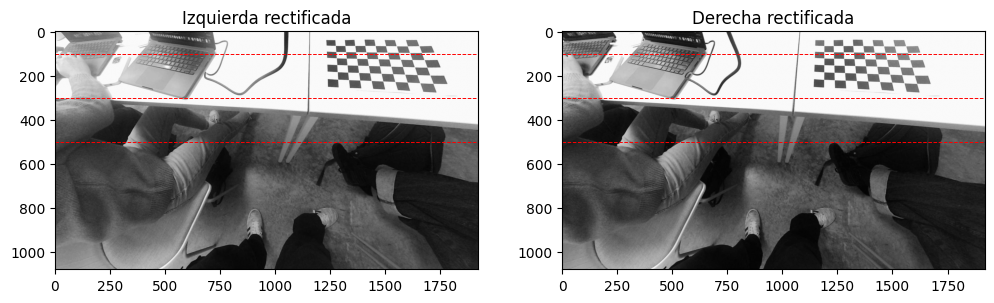

In [4]:
# Mostrar ejemplo de par de imagenes des-distorsionadas y rectificadas

# Cargar los mapas de rectificación
with open("imgs/calibracion/stereo_maps.pkl", "rb") as f:
    maps = pickle.load(f)

left_map_x, left_map_y = maps["left_map_x"], maps["left_map_y"]
right_map_x, right_map_y = maps["right_map_x"], maps["right_map_y"]

# Tomar un par de imágenes de calibración
left_img_path = sorted(glob.glob("imgs/calibracion/*left*.jpg"))[0]
right_img_path = sorted(glob.glob("imgs/calibracion/*right*.jpg"))[0]

imgL = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

# Aplicar rectificación
rectL = cv2.remap(imgL, left_map_x, left_map_y, cv2.INTER_LINEAR)
rectR = cv2.remap(imgR, right_map_x, right_map_y, cv2.INTER_LINEAR)

# Mostrar
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(rectL, cmap="gray")
axes[0].set_title("Izquierda rectificada")
axes[1].imshow(rectR, cmap="gray")
axes[1].set_title("Derecha rectificada")

# Dibujar líneas horizontales para verificar alineación epipolar
for y in [100, 300, 500]:
    axes[0].axhline(y, color='r', linestyle='--', linewidth=0.7)
    axes[1].axhline(y, color='r', linestyle='--', linewidth=0.7)

plt.show()

# Rectificacion, disparidad y profundidad

## Rectificar los pares de imagenes del dataset de reconstruccion

In [5]:
def rectificar_imagenes(path_imgs, path_maps):
    """
    Rectifica todos los pares de imágenes estéreo (left/right) de un directorio usando mapas precomputados.
    
    Parámetros:
        path_imgs (str): Carpeta que contiene las imágenes 'left_*.jpg' y 'right_*.jpg'
        path_maps (str): Ruta al archivo 'stereo_maps.pkl'
    """
    # Crear carpeta de salida si no existe
    output_dir = os.path.join(path_imgs, "rectificadas")
    os.makedirs(output_dir, exist_ok=True)

    # Cargar los mapas de rectificación
    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    left_map_x, left_map_y = maps["left_map_x"], maps["left_map_y"]
    right_map_x, right_map_y = maps["right_map_x"], maps["right_map_y"]

    # Buscar las imágenes left y right
    left_imgs = sorted(glob.glob(os.path.join(path_imgs, "left_*.jpg")))
    right_imgs = sorted(glob.glob(os.path.join(path_imgs, "right_*.jpg")))

    if len(left_imgs) != len(right_imgs):
        print("⚠️ Cantidad distinta de imágenes left/right")
        print(f"Left: {len(left_imgs)}, Right: {len(right_imgs)}")
        return

    print(f"🔹 Rectificando {len(left_imgs)} pares de imágenes...")

    for left_path, right_path in zip(left_imgs, right_imgs):
        # Leer imágenes
        imgL = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
        imgR = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

        # Rectificar
        rectL = cv2.remap(imgL, left_map_x, left_map_y, cv2.INTER_LINEAR)
        rectR = cv2.remap(imgR, right_map_x, right_map_y, cv2.INTER_LINEAR)

        # Nombres de salida
        baseL = os.path.basename(left_path)
        baseR = os.path.basename(right_path)
        outL = os.path.join(output_dir, f"rect_{baseL}")
        outR = os.path.join(output_dir, f"rect_{baseR}")

        # Guardar
        cv2.imwrite(outL, rectL)
        cv2.imwrite(outR, rectR)

    print(f"✅ Imágenes rectificadas guardadas en: {output_dir}")

rectificar_imagenes("imgs/objeto", "imgs/calibracion/stereo_maps.pkl")

🔹 Rectificando 21 pares de imágenes...
✅ Imágenes rectificadas guardadas en: imgs/objeto\rectificadas


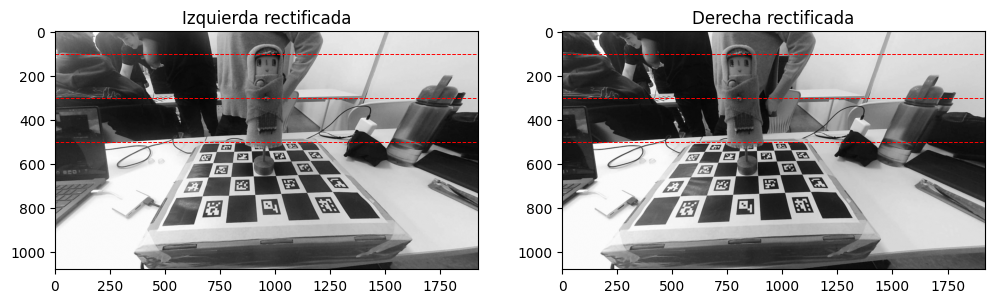

In [6]:
# Mostrar ejemplo de par de imagenes rectificadas del dataset 'objeto'

left_img_path = sorted(glob.glob("imgs/objeto/rectificadas/rect_left_*.jpg"))[0]
right_img_path = sorted(glob.glob("imgs/objeto/rectificadas/rect_right_*.jpg"))[0]

imgL = cv2.imread(left_img_path, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(right_img_path, cv2.IMREAD_GRAYSCALE)

# Mostrar
fig, axes = plt.subplots(1, 2, figsize=(12,6))
axes[0].imshow(imgL, cmap="gray")
axes[0].set_title("Izquierda rectificada")
axes[1].imshow(imgR, cmap="gray")
axes[1].set_title("Derecha rectificada")

# Dibujar líneas horizontales para verificar alineación epipolar
for y in [100, 300, 500]:
    axes[0].axhline(y, color='r', linestyle='--', linewidth=0.7)
    axes[1].axhline(y, color='r', linestyle='--', linewidth=0.7)
    
plt.show()

## Disparidad de la escena

In [35]:
def calcular_mapa_disparidad(imgL, imgR):
    """
    Calcula el mapa de disparidad usando el algoritmo SGBM.
    Devuelve el mapa crudo, listo para la reconstrucción 3D.
    """
    # USAMOS SGBM (Semi-Global Block Matching)
    # Falta ajustar los parámetros a mano!
    stereo_sgbm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=128,
        blockSize=12,
        P1=8 * 3 * blockSize**2,
        P2=32 * 3 * blockSize**2,
        disp12MaxDiff=1,
        uniquenessRatio=8,
        speckleWindowSize=100,
        speckleRange=32,
        preFilterCap=63,
        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    )
    
    # Calcular el mapa de disparidad crudo
    disparity_raw = stereo_sgbm.compute(imgL, imgR)
    
    return disparity_raw

In [36]:
def procesar_dataset_completo(path_rectificadas, output_path):
    """
    Carga todos los pares de imágenes, calcula la disparidad y guarda los
    resultados en subcarpetas 'crudo' y 'visual'.
    """
    print("🔹 Iniciando el proceso de Stereo Matching para todo el dataset...")
    
    # --- MODIFICACIÓN: Crear subcarpetas para los resultados ---
    path_crudo = os.path.join(output_path, 'crudo')
    path_visual = os.path.join(output_path, 'visual')
    os.makedirs(path_crudo, exist_ok=True)
    os.makedirs(path_visual, exist_ok=True)
    # --- Fin de la modificación ---

    left_images = sorted(glob.glob(os.path.join(path_rectificadas, 'rect_left_*.jpg')))
    right_images = sorted(glob.glob(os.path.join(path_rectificadas, 'rect_right_*.jpg')))

    if not left_images or len(left_images) != len(right_images):
        print(f"❌ Error: No se encontraron pares de imágenes consistentes en '{path_rectificadas}'.")
        return

    print(f"Se encontraron {len(left_images)} pares de imágenes.")

    for i, (left_path, right_path) in enumerate(zip(left_images, right_images)):
        print(f"  Procesando par {i+1}/{len(left_images)}...")
        
        imgL = cv2.imread(left_path, 0)
        imgR = cv2.imread(right_path, 0)

        disparity_raw = calcular_mapa_disparidad(imgL, imgR)

        file_basename = os.path.basename(left_path).replace('rect_left_', '').replace('.jpg', '')
        
        # --- MODIFICACIÓN: Guardar en la carpeta 'crudo' ---
        np.save(os.path.join(path_crudo, f'disp_raw_{file_basename}.npy'), disparity_raw)

        # --- MODIFICACIÓN: Guardar en la carpeta 'visual' ---
        disparity_visual = cv2.normalize(disparity_raw, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        disparity_color = cv2.applyColorMap(disparity_visual, cv2.COLORMAP_PLASMA)
        cv2.imwrite(os.path.join(path_visual, f'disp_visual_{file_basename}.jpg'), disparity_color)

    print(f"\n✅ Proceso completado. Mapas de disparidad guardados en:")
    print(f"   - Datos crudos: {path_crudo}")
    print(f"   - Imágenes visuales: {path_visual}")

In [37]:
path_rectificadas = "imgs/objeto/rectificadas"
path_salida_disparidad = "imgs/objeto/disparidad" # Carpeta principal de salida

procesar_dataset_completo(path_rectificadas, path_salida_disparidad)

🔹 Iniciando el proceso de Stereo Matching para todo el dataset...
Se encontraron 21 pares de imágenes.
  Procesando par 1/21...
  Procesando par 2/21...
  Procesando par 3/21...
  Procesando par 4/21...
  Procesando par 5/21...
  Procesando par 6/21...
  Procesando par 7/21...
  Procesando par 8/21...
  Procesando par 9/21...
  Procesando par 10/21...
  Procesando par 11/21...
  Procesando par 12/21...
  Procesando par 13/21...
  Procesando par 14/21...
  Procesando par 15/21...
  Procesando par 16/21...
  Procesando par 17/21...
  Procesando par 18/21...
  Procesando par 19/21...
  Procesando par 20/21...
  Procesando par 21/21...

✅ Proceso completado. Mapas de disparidad guardados en:
   - Datos crudos: imgs/objeto/disparidad\crudo
   - Imágenes visuales: imgs/objeto/disparidad\visual


Las imágenes se guardaron en objeto/disparidad/visual --> para verlas y en objeto/disparidad/crudo para despues usar los números.